<a href="https://colab.research.google.com/github/vyspi394/Deep-Learning/blob/master/Copy_of_CNN_Lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN Image Classification Laboration


Images used in this laboration are from CIFAR 10 (https://en.wikipedia.org/wiki/CIFAR-10). The CIFAR-10 dataset contains 60,000 32x32 color images in 10 different classes. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. There are 6,000 images of each class. Your task is to make a classifier, using a convolutional neural network, that can correctly classify each image into the correct class.

You need to answer all questions in this notebook. 

In [86]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Part 1: What is a convolution

To understand a bit more about convolutions, we will first test the convolution function in scipy using a number of classical filters. 

Convolve the image with Gaussian filter, a Sobel X filter, and a Sobel Y filter, using the function 'convolve2d' in 'signal' from scipy.

https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve2d.html

In a CNN, many filters are applied in each layer, and the filter coefficients are learned through back propagation.

In [0]:
from scipy import signal
import numpy as np

# Get a test image
from scipy import misc
image = misc.ascent()

# Define a help function for creating a Gaussian filter
def matlab_style_gauss2D(shape=(3,3),sigma=0.5):
    """
    2D gaussian mask - should give the same result as MATLAB's
    fspecial('gaussian',[shape],[sigma])
    """
    m,n = [(ss-1.)/2. for ss in shape]
    y,x = np.ogrid[-m:m+1,-n:n+1]
    h = np.exp( -(x*x + y*y) / (2.*sigma*sigma) )
    h[ h < np.finfo(h.dtype).eps*h.max() ] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h

# Create Gaussian filter with certain size and standard deviation
gaussFilter = matlab_style_gauss2D((15,15),4)

# Define filter kernels for SobelX and Sobely
sobelX = np.array([[ 1, 0,  -1],
                    [2, 0, -2],
                    [1, 0, -1]]) 

sobelY = np.array([[ 1, 2,  1],
                    [0, 0, 0],
                    [-1, -2, -1]]) 

In [0]:
# Perform convolution using the function 'convolve2d' for the different filters
filterResponseGauss = signal.convolve2d(image,gaussFilter,boundary='symm',mode='same')
filterResponseSobelX = signal.convolve2d(image,sobelX,boundary='symm',mode='same')
filterResponseSobelY = signal.convolve2d(image,sobelY,boundary='symm',mode='same')

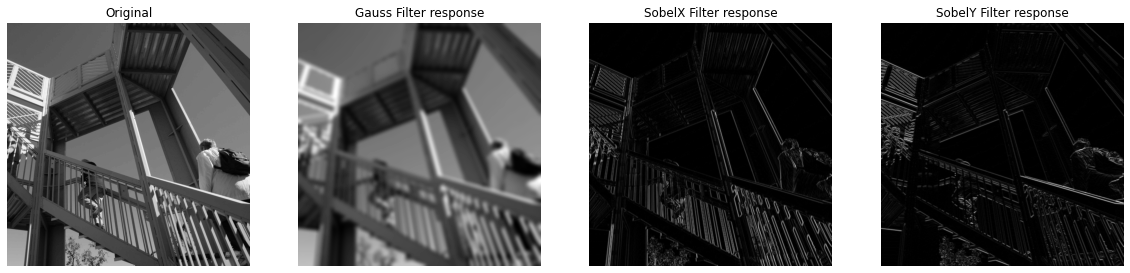

In [89]:
# Show filter responses
import matplotlib.pyplot as plt
fig, (ax_orig, ax_filt1, ax_filt2, ax_filt3) = plt.subplots(1, 4, figsize=(20, 6))
ax_orig.imshow(image, cmap='gray')
ax_orig.set_title('Original')
ax_orig.set_axis_off()
ax_filt1.imshow(np.absolute(filterResponseGauss), cmap='gray')
ax_filt1.set_title('Gauss Filter response')
ax_filt1.set_axis_off()
ax_filt2.imshow(np.absolute(filterResponseSobelX), cmap='gray')
ax_filt2.set_title('SobelX Filter response')
ax_filt2.set_axis_off()
ax_filt3.imshow(np.absolute(filterResponseSobelY), cmap='gray')
ax_filt3.set_title('SobelY Filter response')
ax_filt3.set_axis_off()

##  Part 2: Understanding convolutions

Question 1: What do the 3 different filters (Gaussian, SobelX, SobelY) do to the original image?

Answer 1: Gaussain Filter blurs the image and removes noise from the image.
SobelX filter detects vertical edges, in this case the stair case sticks.
SobelY filter is actually aimed to detect horizontal edges.But since there arent many so only few on the left top close to horizontal edges are detected.

Question 2: What is the size of the original image? How many channels does it have? How many channels does a color image normally have?

Answer 2: The size and channels of our image is displyed in the below cell.In general , channels referes to a componenet of an image.A digital colour image has 3 channels corresponding to RGB.

Question 3: What is the size of the different filters?
Answer 3: The sizes of diferent filters is displyed in the below cell.

Question 4: What is the size of the filter response if mode 'same' is used for the convolution ?
The size of the filter response will be same as the size of our original images.

Question 5: What is the size of the filter response if mode 'valid' is used for the convolution? How does the size of the valid filter response depend on the size of the filter?

Answer 5: The gaussian filter of size 15 x 15 gives a response of size 498 x 498 and the sobelX/Y filters of size 3 x 3 give response of size 510 x 510 when mode 'valid' is used for convolution on an image of size 512 x 512. The valid convolution gives output only when the filter completely overlaps with the image and we will get a full overlap only when the center of the filter is atleast $(f-1)/2$ (for odd filter size $f$) away from the top/bottom and right/left edges of the image. So the size of the response will be $i-(f-1) = i-f+1$ where $i$ is the image size and $f$ is the odd filter size.

Question 6: Why are 'valid' convolutions a problem for CNNs with many layers?

Answer 6:  From above we know that a valid convolution reduces the size of the input image. In a CNN with many layers, the output from one valid convolution will be fed as an input for the next convolution and the size of the output will go on diminishing. With many layers and hence repeated convolutions, we might run out of pixels in the original image.


In [90]:
# Your code for checking sizes of image and filter responses
height,width=image.shape
print('The width of the image is',width)
print('The height of the image is',height)
channels=len(image.shape)
print('The number of channels of the image is ',channels)
gaus_size=gaussFilter.shape
print('The gaussian filter shape is',gaus_size)
sobelX_size=sobelX.shape
print('The sobelX filter shape is',sobelX_size)
sobelY_size=sobelY.shape
print('The sobelY filter shape is',sobelY_size)

The width of the image is 512
The height of the image is 512
The number of channels of the image is  2
The gaussian filter shape is (15, 15)
The sobelX filter shape is (3, 3)
The sobelY filter shape is (3, 3)


##  Part 3: Get a graphics card

Let's make sure that our script can see the graphics card that will be used. The graphics cards will perform all the time consuming convolutions in every training iteration.

In [0]:
import os
import warnings

# Ignore FutureWarning from numpy
warnings.simplefilter(action='ignore', category=FutureWarning)

import keras.backend as K
import tensorflow as tf

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="0";

# Allow growth of GPU memory, otherwise it will always look like all the memory is being used
#physical_devices = tf.config.experimental.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], True) 

##  Part 4: How fast is the graphics card?

Lets investigate how much faster a convolution is with the graphics card

Question 7: Why are the filters of size 7 x 7 x 3, and not 7 x 7 ?               
Answer 7: Images are taken to be matrices with pixel intensities for red,green and blue colour i.e. 3 channels.The filter operates on all the channels of the input. So it has the same depth as the input and the size is 7X7X3.

Question 8: What operation is performed by the 'Conv2D' layer? Is it a standard 2D convolution, as performed by the function signal.convolve2d we just tested?   
Answer 8: Yes, it performs a spatial convolution as the signal.convolve2D.The 'Conv2D' layer, multiplies the filter matrix with the image matrix several times as specified by the number of filters specified by the user.

Question 9: How much faster is the graphics card, compared to the CPU, for convolving a batch of 100 images?                                                
Answer 9: The GPU is 54 times faster than the CPU for convolving a batch of 100 images.

Question 10: How much faster is the graphics card, compared to the CPU, for convolving a batch of 2 images? Explain the difference compared to 100 images.   
Answer 10: The GPU is only 2 times faster than the CPU for convolving a batch of 2 imges which less comared to the case in the previous case.The GPU does not give any significant performance improvement over CPU when the batch size=2. This is because when the batch size is too small, even though we are utilizing the parallelization capabilities of the GPU, the no of iterations in each epoch increases which increases the training time

In [92]:
# Run this cell to compare processing time of CPU and GPU

import timeit

n_images_in_batch = 2
n_images_in_batch = 100

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

# Perform convolutions using the CPU
def cpu():
  with tf.device('/cpu:0'):
    random_images = tf.random.normal((n_images_in_batch, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_images)
    return tf.math.reduce_sum(net_cpu)

# Perform convolutions using the GPU (graphics card)
def gpu():
  with tf.device('/device:GPU:0'):
    random_images = tf.random.normal((n_images_in_batch, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_images)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the convolution several times and measure the time
print('Time (s) to convolve 32 filters of size 7 x 7 x 3 over 100 random images of size 100 x 100 x 3'
      ' (batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32 filters of size 7 x 7 x 3 over 100 random images of size 100 x 100 x 3 (batch x height x width x channel). Sum of ten runs.
CPU (s):
3.668544416000259
GPU (s):
0.059742013999311894
GPU speedup over CPU: 61x


In [93]:
import timeit

n_images_in_batch = 2

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

# Perform convolutions using the CPU
def cpu():
  with tf.device('/cpu:0'):
    random_images = tf.random.normal((n_images_in_batch, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_images)
    return tf.math.reduce_sum(net_cpu)

# Perform convolutions using the GPU (graphics card)
def gpu():
  with tf.device('/device:GPU:0'):
    random_images = tf.random.normal((n_images_in_batch, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_images)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the convolution several times and measure the time
print('Time (s) to convolve 32 filters of size 7 x 7 x 3 over 100 random images of size 100 x 100 x 3'
      ' (batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32 filters of size 7 x 7 x 3 over 100 random images of size 100 x 100 x 3 (batch x height x width x channel). Sum of ten runs.
CPU (s):
0.1268209999998362
GPU (s):
0.05960311200033175
GPU speedup over CPU: 2x


##  Part 5:  Load data
Time to make a 2D CNN. Load the images and labels from keras.datasets, this cell is already finished.

In [94]:
from keras.datasets import cifar10
import numpy as np

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Download CIFAR train and test data
(Xtrain, Ytrain), (Xtest, Ytest) = cifar10.load_data()

print("Training images have size {} and labels have size {} ".format(Xtrain.shape, Ytrain.shape))
print("Test images have size {} and labels have size {} \n ".format(Xtest.shape, Ytest.shape))

# Reduce the number of images for training and testing to 10000 and 2000 respectively, 
# to reduce processing time for this laboration
Xtrain = Xtrain[0:10000]
Ytrain = Ytrain[0:10000]

Xtest = Xtest[0:2000]
Ytest = Ytest[0:2000]

Ytestint = Ytest

print("Reduced training images have size %s and labels have size %s " % (Xtrain.shape, Ytrain.shape))
print("Reduced test images have size %s and labels have size %s \n" % (Xtest.shape, Ytest.shape))

# Check that we have some training examples from each class
for i in range(10):
    print("Number of training examples for class {} is {}" .format(i,np.sum(Ytrain == i)))

Training images have size (50000, 32, 32, 3) and labels have size (50000, 1) 
Test images have size (10000, 32, 32, 3) and labels have size (10000, 1) 
 
Reduced training images have size (10000, 32, 32, 3) and labels have size (10000, 1) 
Reduced test images have size (2000, 32, 32, 3) and labels have size (2000, 1) 

Number of training examples for class 0 is 1005
Number of training examples for class 1 is 974
Number of training examples for class 2 is 1032
Number of training examples for class 3 is 1016
Number of training examples for class 4 is 999
Number of training examples for class 5 is 937
Number of training examples for class 6 is 1030
Number of training examples for class 7 is 1001
Number of training examples for class 8 is 1025
Number of training examples for class 9 is 981


##  Part 6: Plotting

Lets look at some of the training examples, this cell is already finished. You will see different examples every time you run the cell.

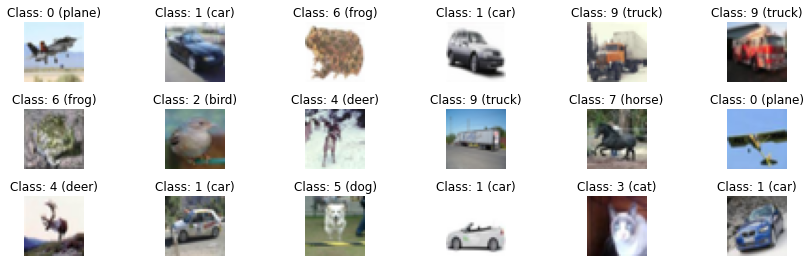

In [95]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
for i in range(18):
    idx = np.random.randint(7500)
    label = Ytrain[idx,0]
    
    plt.subplot(3,6,i+1)
    plt.tight_layout()
    plt.imshow(Xtrain[idx])
    plt.title("Class: {} ({})".format(label, classes[label]))
    plt.axis('off')
plt.show()

##   Part 7: Split data into training, validation and testing
Split your training data into training (Xtrain, Ytrain) and validation (Xval, Yval), so that we have training, validation and test datasets (as in the previous laboration). We use a function in scikit learn. Use 25% of the data for validation.

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [96]:
from sklearn.model_selection import train_test_split
Xtrain,Xval,Ytrain,Yval=train_test_split(Xtrain,Ytrain,test_size=0.25)
# Print the size of training data, validation data and test data
print("Reduced training images have size %s and labels have size %s " % (Xtrain.shape, Ytrain.shape))
print("Reduced validation images have size %s and labels have size %s \n" % (Xval.shape, Yval.shape))

Reduced training images have size (7500, 32, 32, 3) and labels have size (7500, 1) 
Reduced validation images have size (2500, 32, 32, 3) and labels have size (2500, 1) 



##  Part 8: Preprocessing of images

Lets perform some preprocessing. The images are stored as uint8, i.e. 8 bit unsigned integers, but need to be converted to 32 bit floats. We also make sure that the range is -1 to 1, instead of 0 - 255. This cell is already finished.

In [0]:
# Convert datatype for Xtrain, Xval, Xtest, to float32
Xtrain = Xtrain.astype('float32')
Xval = Xval.astype('float32')
Xtest = Xtest.astype('float32')

# Change range of pixel values to [-1,1]
Xtrain = Xtrain / 127.5 - 1
Xval = Xval / 127.5 - 1
Xtest = Xtest / 127.5 - 1

##  Part 9: Preprocessing of labels

The labels (Y) need to be converted from e.g. '4' to "hot encoded", i.e. to a vector of type [0, 0, 0, 1, 0, 0, 0, 0, 0, 0] . We use a function in Keras, see https://keras.io/utils/#to_categorical

In [98]:
from keras.utils import to_categorical

# Print shapes before converting the labels
print("Reduced training labels have size %s and validation labels have size %s " % (Ytrain.shape, Yval.shape))

# Your code for converting Ytrain, Yval, Ytest to categorical
Ytrain_categorical=to_categorical(Ytrain)
Yval_categorical=to_categorical(Yval)
Ytest_categorical=to_categorical(Ytest)
# Print shapes after converting the labels
print("Reduced training labels have size %s and validation labels have size %s " % (Ytrain_categorical.shape, Yval_categorical.shape))

Reduced training labels have size (7500, 1) and validation labels have size (2500, 1) 
Reduced training labels have size (7500, 10) and validation labels have size (2500, 10) 


##  Part 10: 2D CNN
Finish this code to create the image classifier, using a 2D CNN. Each convolutional layer will contain 2D convolution, batch normalization and max pooling. After the convolutional layers comes a flatten layer and a number of intermediate dense layers. The convolutional layers should take the number of filters as an argument, use a kernel size of 3 x 3, 'same' padding, and relu activation functions. The number of filters will double with each convolutional layer. The max pooling layers should have a pool size of 2 x 2. The intermediate dense layers before the final dense layer should take the number of nodes as an argument, use relu activation functions, and be followed by batch normalization. The final dense layer should have 10 nodes (= the number of classes in this laboration) and 'softmax' activation. Here we start with the Adam optimizer.

Relevant functions are

`model.add()`, adds a layer to the network

`Dense()`, a dense network layer

`Conv2D()`, performs 2D convolutions with a number of filters with a certain size (e.g. 3 x 3). 

`BatchNormalization()`, perform batch normalization

`MaxPooling2D()`, saves the max for a given pool size, results in down sampling

`Flatten()`, flatten a multi-channel tensor into a long vector

`model.compile()`, compile the model, add " metrics=['accuracy'] " to print the classification accuracy during the training

See https://keras.io/layers/core/ for information on how the `Dense()` and `Flatten()` functions work

See https://keras.io/layers/convolutional/ for information on how `Conv2D()` works

See https://keras.io/layers/pooling/ for information on how `MaxPooling2D()` works

Import a relevant cost function for multi-class classification from keras.losses (https://keras.io/losses/)

See https://keras.io/models/model/ for how to compile, train and evaluate the model

In [0]:
from keras.models import Sequential, Model
from keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy

# Set seed from random number generator, for better comparisons
from numpy.random import seed
seed(123)

def build_CNN(input_shape, n_conv_layers=2, n_filters=16, n_dense_layers=0, n_nodes=50, use_dropout=False, learning_rate=0.01,drop_rate=0.5,weight_constraint=None):

    # Setup a sequential model
    model = Sequential()

    # Add first convolutional layer to the model, requires input shape
    model.add(Conv2D(n_filters, activation='relu',input_shape=input_shape,kernel_size=(3,3),padding='same',kernel_constraint=weight_constraint))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same', data_format=None))
    model.add(BatchNormalization())

    # Add remaining convolutional layers to the model, the number of filters should increase a factor 2 for each layer
    for i in range(n_conv_layers-1):
      model.add(Conv2D(filters=(n_filters*(2**(i+1))), kernel_size=(3,3),padding='same',activation='relu',kernel_constraint=weight_constraint))
      model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same', data_format=None))
      model.add(BatchNormalization())

    # Add flatten the last layer
    model.add(Flatten())

    # Add intermediate dense layers
    for i in range(1,n_dense_layers-1):
      model.add(Dense(n_nodes, activation='relu',kernel_constraint=weight_constraint))
      if(use_dropout==True):
        model.add(Dropout(drop_rate))
      model.add(BatchNormalization())

    # Add final dense layer
    model.add(Dense(10, activation='softmax',kernel_constraint=weight_constraint))

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
    return model

In [0]:
# Lets define a help function for plotting the training results
import matplotlib.pyplot as plt
def plot_results(history):
    
    loss = history.history['loss']
    acc = history.history['accuracy']
    val_loss = history.history['val_loss']
    val_acc = history.history['val_accuracy']
    
    plt.figure(figsize=(10,4))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(loss)
    plt.plot(val_loss)
    plt.legend(['Training','Validation'])

    plt.figure(figsize=(10,4))
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(acc)
    plt.plot(val_acc)
    plt.legend(['Training','Validation'])

    plt.show()

## Part 11: Train 2D CNN

Time to train the 2D CNN, start with 2 convolutional layers, no intermediate dense layers, learning rate = 0.01. The first convolutional layer should have 16 filters (which means that the second convolutional layer will have 32 filters).

Relevant functions

`build_CNN`, the function we defined in Part 10, call it with the parameters you want to use

`model.fit()`, train the model with some training data

`model.evaluate()`, apply the trained model to some test data

## 2 convolutional layers, no intermediate dense layers

In [101]:
# Setup some training parameters
batch_size = 100
epochs = 20
input_shape = (Xtrain.shape[1:])
# Build model
model1 = build_CNN(input_shape=input_shape,n_conv_layers=2)

# Train the model  using training data and validation data
history1 = model1.fit(Xtrain,Ytrain_categorical,validation_data = (Xval, Yval_categorical),batch_size = batch_size, epochs = epochs)

Train on 7500 samples, validate on 2500 samples
Epoch 1/20
7500/7500 [==============================] - 1s 166us/step - loss: 1.8487 - accuracy: 0.3743 - val_loss: 2.1124 - val_accuracy: 0.1940
Epoch 2/20
7500/7500 [==============================] - 1s 108us/step - loss: 1.3611 - accuracy: 0.5161 - val_loss: 2.2559 - val_accuracy: 0.2016
Epoch 3/20
7500/7500 [==============================] - 1s 106us/step - loss: 1.1596 - accuracy: 0.5921 - val_loss: 2.2226 - val_accuracy: 0.2648
Epoch 4/20
7500/7500 [==============================] - 1s 106us/step - loss: 1.0318 - accuracy: 0.6401 - val_loss: 1.8469 - val_accuracy: 0.3576
Epoch 5/20
7500/7500 [==============================] - 1s 106us/step - loss: 0.9315 - accuracy: 0.6773 - val_loss: 1.5530 - val_accuracy: 0.4456
Epoch 6/20
7500/7500 [==============================] - 1s 107us/step - loss: 0.8272 - accuracy: 0.7141 - val_loss: 1.4879 - val_accuracy: 0.4808
Epoch 7/20
7500/7500 [==============================] - 1s 107us/step - loss

In [102]:
# Evaluate the trained model on test set, not used in training or validation
score = model1.evaluate(Xtest, Ytest_categorical,batch_size=batch_size)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

2000/2000 [==============================] - 0s 54us/step
Test loss: 1.7664
Test accuracy: 0.5560


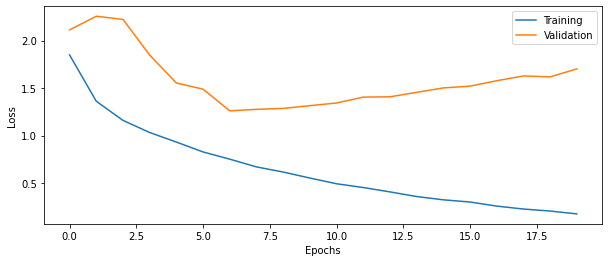

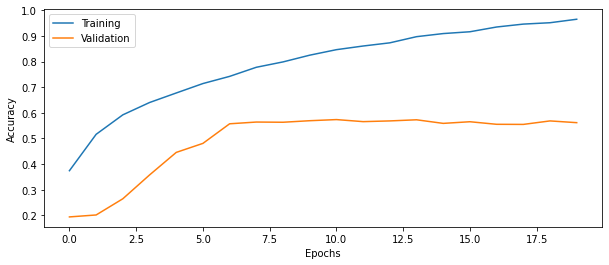

In [103]:
# Plot the history from the training run
plot_results(history1)

## Part 12: Improving performance
Write down the test accuracy, are you satisfied with the classifier performance (random chance is 10%) ?                                                         
Answer : There test accuracy is less compared to the training data.

Question 11: How big is the difference between training and test accuracy?        
Answer 11 : The training and test accuracy has around 50 % difference. This shows the model has over fit the traning data and needs some regularization.It can be said that the model has an acceptable classification accuracy considering 10% as random chance.

Question 12: How busy is the GPU for a batch size of 100? How much GPU memory is used? Hint: run 'watch nvidia-smi' on the cloud computer during training.

Answer 12: We have run everything on google colab for tis lab. Hence we do not have the stats for GPU parameter.

Question 13: For the DNN laboration we used a batch size of 10,000, why do we need to use a smaller batch size in this laboration?

Answer 13 : Batch size is much lesser in the case of CNN (we have greater number of parameters than DNN) because the model gets tranined faster with smaller batch sizes.

## 2 convolutional layers, 1 intermediate dense layer (50 nodes)

In [104]:
# Setup some training parameters
batch_size = 100
epochs = 20
input_shape = (Xtrain.shape[1:])
# Build model
model2 = build_CNN(input_shape=input_shape,n_conv_layers=2,n_dense_layers=1,n_nodes=50)

# Train the model  using training data and validation data
history2 = model2.fit(Xtrain,Ytrain_categorical,validation_data = (Xval, Yval_categorical),batch_size = batch_size, epochs = epochs)

Train on 7500 samples, validate on 2500 samples
Epoch 1/20
7500/7500 [==============================] - 1s 158us/step - loss: 1.8474 - accuracy: 0.3795 - val_loss: 2.1571 - val_accuracy: 0.1716
Epoch 2/20
7500/7500 [==============================] - 1s 106us/step - loss: 1.3308 - accuracy: 0.5356 - val_loss: 2.4899 - val_accuracy: 0.1776
Epoch 3/20
7500/7500 [==============================] - 1s 102us/step - loss: 1.1297 - accuracy: 0.6024 - val_loss: 2.6311 - val_accuracy: 0.2000
Epoch 4/20
7500/7500 [==============================] - 1s 102us/step - loss: 0.9895 - accuracy: 0.6569 - val_loss: 2.3999 - val_accuracy: 0.2188
Epoch 5/20
7500/7500 [==============================] - 1s 104us/step - loss: 0.8773 - accuracy: 0.6981 - val_loss: 2.1644 - val_accuracy: 0.3252
Epoch 6/20
7500/7500 [==============================] - 1s 102us/step - loss: 0.7761 - accuracy: 0.7392 - val_loss: 1.7418 - val_accuracy: 0.4196
Epoch 7/20
7500/7500 [==============================] - 1s 102us/step - loss

In [105]:
# Evaluate the trained model on test set, not used in training or validation
score = model2.evaluate(Xtest, Ytest_categorical,batch_size=batch_size)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

2000/2000 [==============================] - 0s 49us/step
Test loss: 1.7482
Test accuracy: 0.5830


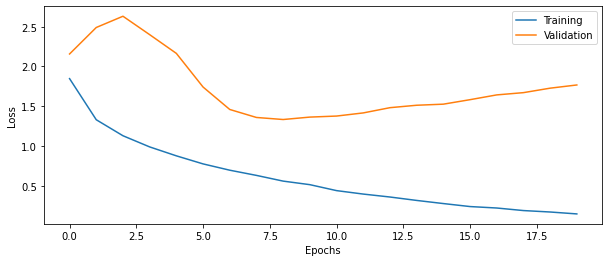

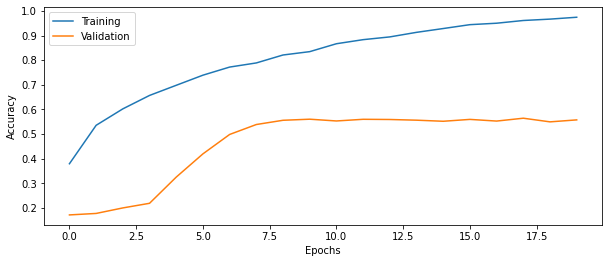

In [106]:
# Plot the history from the training run
plot_results(history2)

## 4 convolutional layers, 1 intermediate dense layer (50 nodes)

In [107]:
# Setup some training parameters
batch_size = 100
epochs = 20
input_shape = Xtrain.shape[1:]

# Build model
model3 = build_CNN(input_shape=input_shape,n_conv_layers=4,n_dense_layers=1,n_nodes=50)

# Train the model  using training data and validation data
history3 = model3.fit(Xtrain,Ytrain_categorical,validation_data=(Xval,Yval_categorical),batch_size = batch_size, epochs = epochs)

Train on 7500 samples, validate on 2500 samples
Epoch 1/20
7500/7500 [==============================] - 2s 255us/step - loss: 1.7194 - accuracy: 0.4008 - val_loss: 2.2527 - val_accuracy: 0.1996
Epoch 2/20
7500/7500 [==============================] - 1s 154us/step - loss: 1.1317 - accuracy: 0.5991 - val_loss: 2.3221 - val_accuracy: 0.2008
Epoch 3/20
7500/7500 [==============================] - 1s 154us/step - loss: 0.8583 - accuracy: 0.7080 - val_loss: 2.5425 - val_accuracy: 0.2236
Epoch 4/20
7500/7500 [==============================] - 1s 151us/step - loss: 0.6187 - accuracy: 0.8033 - val_loss: 2.1730 - val_accuracy: 0.3116
Epoch 5/20
7500/7500 [==============================] - 1s 155us/step - loss: 0.4450 - accuracy: 0.8697 - val_loss: 1.7589 - val_accuracy: 0.4160
Epoch 6/20
7500/7500 [==============================] - 1s 154us/step - loss: 0.2947 - accuracy: 0.9327 - val_loss: 1.6720 - val_accuracy: 0.4724
Epoch 7/20
7500/7500 [==============================] - 1s 150us/step - loss

In [108]:
# Evaluate the trained model on test set, not used in training or validation
score = model3.evaluate(Xtest,Ytest_categorical,batch_size=batch_size)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

2000/2000 [==============================] - 0s 51us/step
Test loss: 1.6637
Test accuracy: 0.5815


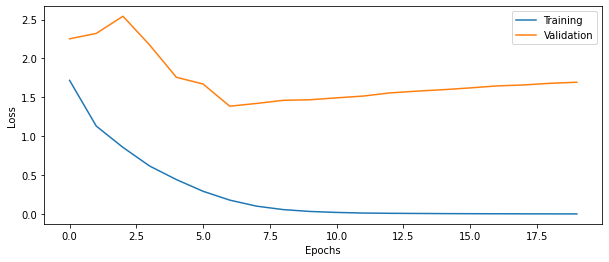

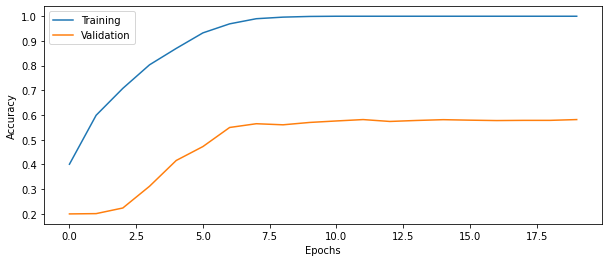

In [109]:
# Plot the history from the training run
plot_results(history3)

##  Part 13: Plot the CNN architecture

To understand your network better, print the architecture using `model.summary()`

Question 14: How many trainable parameters does your network have? Which part of the network contains most of the parameters?

Answer 14: The CNN has a total of 123,700 trainable parameters. The last convolutional layer contains the most number of parameters. The last Conv2D layer has 128 filters of size 3 x 3 and hence 3 x 3 x 64 weights (64 is the number of input channels to the last Conv2D layer) and 1 bias for each filter. Therefore, this layer has ((3 x 3 x 64) + 1) x 128 = 73856 parameters in total.

The dense layer contains the next most number of parameters as every neuron is connected to every other neuron from the previous layer. The fully connected layer has 50 nodes each connected to all of the 512 nodes from the flattened layer. Hence it has 50 x 512 weights and 50 biases = 25650 total parameters.

Question 15: What is the input to and output of a Conv2D layer? What are the dimensions of the input and output? 

Answer 15: The input to a Conv2D layer is an input image with channels and the output is a convolved image with (usually higher) output channels. These convolved image channels are called feature maps. Each output channel (feature map) is the output of one filter applied to the previous layer. If the input dimensions to a conv2D layer with $n_{filter}$ filters are $i_{width}$ x $i_{height}$ x $i_{channels}$ then the output of the layer has dimenions $i_{width}$ x $i_{height}$ x $n_{filter}$.

Question 16: Is the batch size always the first dimension of each 4D tensor? Check the documentation for Conv2D, https://keras.io/layers/convolutional/

Answer 16:Yes, the first dimension of a 4D tensor is always the batch_size. It does not depend on the data_format parameter of the Conv2D layer. If the data_format = channels_last, then the dimension of the 4D tensor is (batch_size, rows, cols, channels) and if the data_format = channels_first, then the dimension of the 4D tensor is (batch_size, channels, rows, cols).
 
Question 17: If a convolutional layer that contains 128 filters is applied to an input with 32 channels, what is the number of channels in the output?         

Answer 17: Output Number of channels =  Number of filters in Convolution layer.
Output Number of channels=128.The number of output channels is the same as the number of filters in the convolutional layer. Each of the 128 filters in the Conv2D layer has 32 filter kernels (equal to the number of input channels). So we will get one output channel for each filter which is the sum of all the 32 kernels in that filter convolved with the 32 input channels respectively.

Question 18: Why is the number of parameters in each Conv2D layer *not* equal to the number of filters times the number of filter coefficients per filter (plus biases)?                                                                   
Answer 18: The number of filter coefficients per filter is $f_{width}$ x $f_{height}$ but each filter has depth (filter kernels) equal to the number of input channels i.e. $f_{kernels}$=$i_{channels}$. The filter output is the sum over all the kernel outputs. Hence the number of parameters in a Conv2D layer = (($f_{width}$ x $f_{height}$ x $f_{kernels}$ + 1) x $n_{filter}$ where $f_{kernels}$=$i_{channels}$. The 1 is for a bias per filter.

Question 19: How does MaxPooling help in reducing the number of parameters to train?                                                                                                                                                    Answer 19: MaxPooling layer with pool size=2 reduces the output dimension by half of the input dimension. For every 2 x 2 neighbourhood in the input image, we take the maximum value as the output. The default stride is equal to the pool size. This reduces the output dimension and hence the parameters associated with the successive layers in the network. MaxPooling itself doesn't have any learnable parameters.

In [110]:
# Print network architecture

model3.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_43 (Conv2D)           (None, 32, 32, 16)        448       
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 16, 16, 16)        0         
_________________________________________________________________
batch_normalization_43 (Batc (None, 16, 16, 16)        64        
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 16, 16, 32)        4640      
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 8, 8, 32)          0         
_________________________________________________________________
batch_normalization_44 (Batc (None, 8, 8, 32)          128       
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 8, 8, 64)        

##  Part 14: Dropout regularization

Add dropout regularization to each intermediate dense layer, dropout probability 50%.

Question 20: How much did the test accuracy improve with dropout, compared to without dropout?

Answer 20: The test accuracy has decreased after dropout which means that we have underfit the data by droping out few neurons.


Question 21: What other types of regularization can be applied? How can you add L2 regularization for the convolutional layers?

Answer 21: To apply L2 regularization, we need to include the parameter kernel_regularizer=l2 while building the model.


## 4 convolutional layers, 1 intermediate dense layer (50 nodes), dropout

In [111]:
# Setup some training parameters
batch_size = 100
epochs = 20
input_shape = Xtrain.shape[1:]

# Build model
model4 = build_CNN(input_shape=input_shape,n_conv_layers=4,n_dense_layers=1,n_nodes=50,use_dropout=True)

# Train the model  using training data and validation data
history4 = model4.fit(Xtrain,Ytrain_categorical,validation_data=(Xval,Yval_categorical),batch_size=batch_size,epochs=epochs)

Train on 7500 samples, validate on 2500 samples
Epoch 1/20
7500/7500 [==============================] - 2s 267us/step - loss: 1.6877 - accuracy: 0.4205 - val_loss: 2.2760 - val_accuracy: 0.1324
Epoch 2/20
7500/7500 [==============================] - 1s 149us/step - loss: 1.0984 - accuracy: 0.6176 - val_loss: 2.7779 - val_accuracy: 0.1008
Epoch 3/20
7500/7500 [==============================] - 1s 149us/step - loss: 0.8214 - accuracy: 0.7268 - val_loss: 2.7448 - val_accuracy: 0.1820
Epoch 4/20
7500/7500 [==============================] - 1s 152us/step - loss: 0.5905 - accuracy: 0.8145 - val_loss: 2.5951 - val_accuracy: 0.2060
Epoch 5/20
7500/7500 [==============================] - 1s 147us/step - loss: 0.4116 - accuracy: 0.8865 - val_loss: 2.0483 - val_accuracy: 0.3576
Epoch 6/20
7500/7500 [==============================] - 1s 146us/step - loss: 0.2612 - accuracy: 0.9417 - val_loss: 1.6274 - val_accuracy: 0.4780
Epoch 7/20
7500/7500 [==============================] - 1s 149us/step - loss

In [112]:
# Evaluate the trained model on test set, not used in training or validation
score = model4.evaluate(Xtest,Ytest_categorical,batch_size=batch_size)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

2000/2000 [==============================] - 0s 55us/step
Test loss: 1.7203
Test accuracy: 0.5880


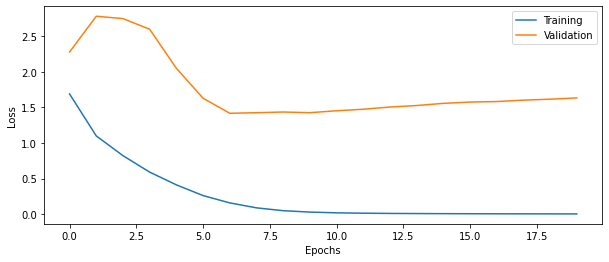

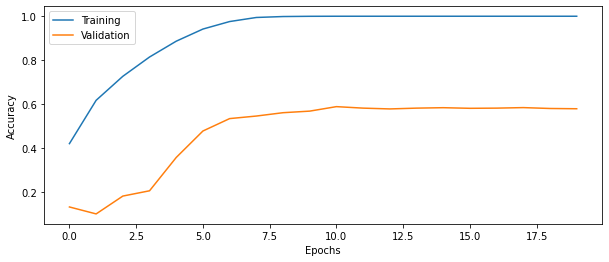

In [113]:
# Plot the history from the training run
plot_results(history4)

##  Part 15: Tweaking performance

You have now seen the basic building blocks of a 2D CNN. To further improve performance involves changing the number of convolutional layers, the number of filters per layer, the number of intermediate dense layers, the number of nodes in the intermediate dense layers, batch size, learning rate, number of epochs, etc. Spend some time (30 - 90 minutes) testing different settings.

Question 22: How high test accuracy can you obtain? What is your best configuration? 

Answer 22: The highest test accuracy is 72% with 5 convolution layers with first layer having 128 filters, 1 dense layer, 60 nodes, 0.00001 learning rate and 0.5 drop out rate. The batch size and epochs are 100 and 50 respectively.

## Your best config

Train on 7500 samples, validate on 2500 samples
Epoch 1/50
7500/7500 [==============================] - 3s 417us/step - loss: 2.1880 - accuracy: 0.3887 - val_loss: 3.1578 - val_accuracy: 0.1440
Epoch 2/50
7500/7500 [==============================] - 2s 300us/step - loss: 1.2593 - accuracy: 0.5677 - val_loss: 4.3152 - val_accuracy: 0.1132
Epoch 3/50
7500/7500 [==============================] - 2s 299us/step - loss: 0.9390 - accuracy: 0.6731 - val_loss: 4.7775 - val_accuracy: 0.1268
Epoch 4/50
7500/7500 [==============================] - 2s 297us/step - loss: 0.6695 - accuracy: 0.7659 - val_loss: 3.4389 - val_accuracy: 0.2328
Epoch 5/50
7500/7500 [==============================] - 2s 297us/step - loss: 0.3938 - accuracy: 0.8652 - val_loss: 3.2091 - val_accuracy: 0.2260
Epoch 6/50
7500/7500 [==============================] - 2s 302us/step - loss: 0.2197 - accuracy: 0.9273 - val_loss: 2.5046 - val_accuracy: 0.3652
Epoch 7/50
7500/7500 [==============================] - 2s 299us/step - loss

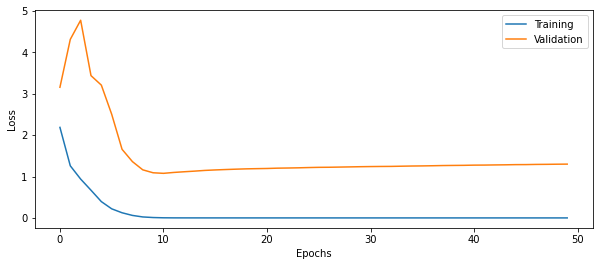

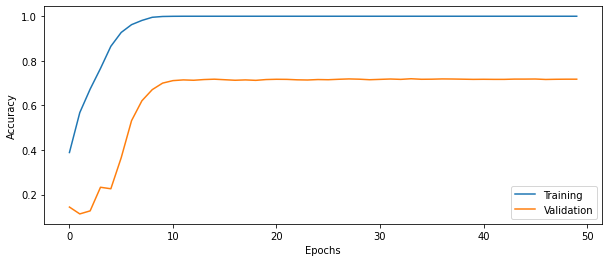

In [114]:
# Setup some training parameters
batch_size = 100
epochs = 50
input_shape = Xtrain.shape[1:]

# Build model
model_exp = build_CNN(input_shape=input_shape,n_conv_layers=4,n_dense_layers=1,n_nodes=60,use_dropout=True,n_filters=128,learning_rate=0.00001)

# Train the model  using training data and validation data
history_exp = model_exp.fit(Xtrain,Ytrain_categorical,validation_data=(Xval,Yval_categorical),batch_size=batch_size,epochs=epochs)

# Evaluate the trained model on test set, not used in training or validation
score = model_exp.evaluate(Xtest,Ytest_categorical,batch_size=batch_size)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

# Plot the history from the training run
plot_results(history_exp)

##  Part 16: Rotate the test images

How high is the test accuracy if we rotate the test images? In other words, how good is the CNN at generalizing to rotated images?

Rotate each test image 90 degrees, the cells are already finished.

Question 23: What is the test accuracy for rotated test images, compared to test images without rotation? Explain the difference in accuracy.

Answer 23: The test accuracy for the rotated images is only 29.20 % which is very less. This is because the training has been done on unrotated images.It is not very better than classifying images at random chance. The CNN model is trained to look for the learned features in only a certain orientations. This is why it results in a low test accuracy.

In [0]:
def myrotate(images):

    images_rot = np.rot90(images, axes=(1,2))
    
    return images_rot

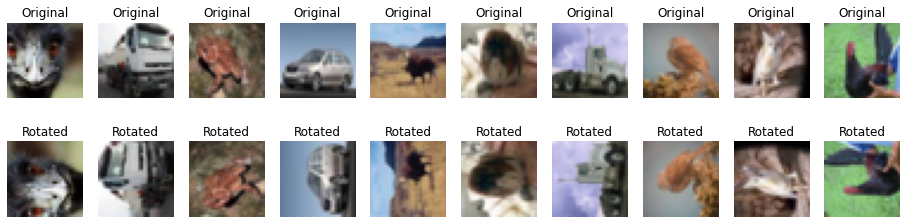

In [116]:
# Rotate the test images 90 degrees
Xtest_rotated = myrotate(Xtest)

# Look at some rotated images
plt.figure(figsize=(16,4))
for i in range(10):
    idx = np.random.randint(500)
    
    plt.subplot(2,10,i+1)
    plt.imshow(Xtest[idx]/2+0.5)
    plt.title("Original")
    plt.axis('off')
    
    plt.subplot(2,10,i+11)
    plt.imshow(Xtest_rotated[idx]/2+0.5)
    plt.title("Rotated")
    plt.axis('off')
plt.show()


In [117]:
# Evaluate the trained model on rotated test set
score = model_exp.evaluate(Xtest_rotated,Ytest_categorical)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

2000/2000 [==============================] - 0s 220us/step
Test loss: 5.4948
Test accuracy: 0.2825


##  Part 17: Augmentation using Keras `ImageDataGenerator`

We can increase the number of training images through data augmentation (we now ignore that CIFAR10 actually has 60 000 training images). Image augmentation is about creating similar images, by performing operations such as rotation, scaling, elastic deformations and flipping of existing images. This will prevent overfitting, especially if all the training images are in a certain orientation.

We will perform the augmentation on the fly, using a built-in function in Keras, called `ImageDataGenerator`

See https://keras.io/preprocessing/image/

In [0]:
# Get all 60 000 training images again. ImageDataGenerator manages validation data on its own
(Xtrain, Ytrain), _ = cifar10.load_data()

# Reduce number of images to 10,000
Xtrain = Xtrain[0:10000]
Ytrain = Ytrain[0:10000]

# Change data type and rescale range
Xtrain = Xtrain.astype('float32')
Xtrain = Xtrain / 127.5 - 1

# Convert labels to hot encoding
Ytrain_categorical = to_categorical(Ytrain, 10)

In [0]:
# Set up a data generator with on-the-fly data augmentation, 20% validation split
# Use a rotation range of 30 degrees, horizontal and vertical flipping
from keras.preprocessing.image import ImageDataGenerator

datagen=ImageDataGenerator(rotation_range=30,vertical_flip=True,horizontal_flip=True,validation_split=0.20)

# Setup a flow for training data, assume that we can fit all images into CPU memory
training_flow=datagen.flow(x=Xtrain,y=Ytrain_categorical,subset="training",batch_size=len(Xtrain)*0.8)

# Setup a flow for validation data, assume that we can fit all images into CPU memory
validation_flow=datagen.flow(x=Xval,y=Yval_categorical,subset="validation",batch_size=len(Xtrain)*0.2)

## Part 18: What about big data?

Question 24: How would you change the code for the image generator if you cannot fit all training images in CPU memory? What is the disadvantage of doing that change?

Answer 24: Subsetting the traning images which might result the model "seeing" a smaller number of images.Or we can consider the images in batches and augment them. We have used a batch size of 100.

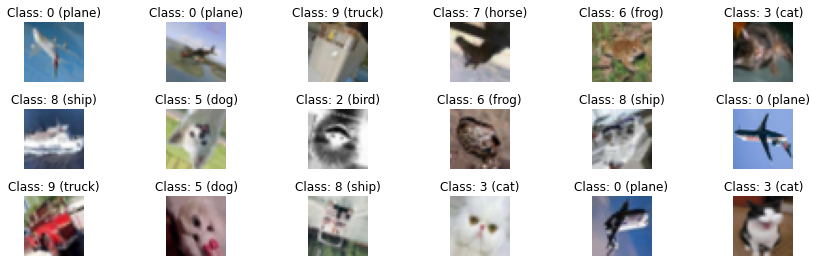

In [120]:
# Plot some augmented images
plot_datagen = datagen.flow(Xtrain, Ytrain_categorical, batch_size=1)

plt.figure(figsize=(12,4))
for i in range(18):
    (im, label) = plot_datagen.next()
    im = (im[0] + 1) * 127.5
    im = im.astype('int')
    label = np.flatnonzero(label)[0]
    
    plt.subplot(3,6,i+1)
    plt.tight_layout()
    plt.imshow(im)
    plt.title("Class: {} ({})".format(label, classes[label]))
    plt.axis('off')
plt.show()

## Part 19: Train the CNN with images from the generator

See https://keras.io/models/model/ for how to use model.fit_generator instead of model.fit for training

To make the comparison fair to training without augmentation

    steps_per_epoch should be set to: len(Xtrain)*(1 - validation_split)/batch_size

    validation_steps should be set to: len(Xtrain)*validation_split/batch_size

Question 25: How quickly is the training accuracy increasing compared to without augmentation? Explain why there is a difference compared to without augmentation. What parameter is necessary to change to perform more training?

Answer 25: With augmentation, we have tranined on rotated images hence it performs better on rotated images. But without augmentation,this traning has not been done so the accuracy of this model is less on rotated images compared to the augmented model. The parameter validation_split needs to be decreased to increase more training.

Question 26: What other types of image augmentation can be applied, compared to what we use here?

Answers 26: We can create new images of the classes and train on the newly generated images as well. Images can also be cropped, translated (shifted left, right, up or down) and images can also be mixed.

In [121]:
# Setup some training parameters
batch_size = 100
epochs = 200
input_shape = Xtrain.shape[1:]

#Build your model(your best config)
model6 = build_CNN(input_shape=input_shape,n_conv_layers=5,n_dense_layers=1,n_nodes=60,use_dropout=True,n_filters=128,learning_rate=0.00001)

validation_split=0.2
    
# Train the model using on the fly augmentation
datagen_train = datagen.flow(x=Xtrain, y=Ytrain_categorical, batch_size=batch_size, subset="training")
datagen_valid = datagen.flow(x=Xtrain, y=Ytrain_categorical, batch_size=batch_size, subset="validation")

history6 = model6.fit_generator(generator=datagen_train, steps_per_epoch=len(Xtrain)*(1-validation_split)/batch_size, epochs=epochs,
                                validation_data=datagen_valid, validation_steps=len(Xtrain)*validation_split/batch_size)

Epoch 1/200
80/80 [==============================] - 8s 101ms/step - loss: 2.6386 - accuracy: 0.3014 - val_loss: 4.7477 - val_accuracy: 0.1765
Epoch 2/200
80/80 [==============================] - 7s 87ms/step - loss: 1.6829 - accuracy: 0.3957 - val_loss: 4.2140 - val_accuracy: 0.1065
Epoch 3/200
80/80 [==============================] - 7s 86ms/step - loss: 1.5792 - accuracy: 0.4442 - val_loss: 3.5204 - val_accuracy: 0.1530
Epoch 4/200
80/80 [==============================] - 7s 85ms/step - loss: 1.5179 - accuracy: 0.4678 - val_loss: 4.3079 - val_accuracy: 0.1335
Epoch 5/200
80/80 [==============================] - 7s 84ms/step - loss: 1.4273 - accuracy: 0.4946 - val_loss: 3.4009 - val_accuracy: 0.2010
Epoch 6/200
80/80 [==============================] - 7s 86ms/step - loss: 1.3641 - accuracy: 0.5171 - val_loss: 2.3851 - val_accuracy: 0.2655
Epoch 7/200
80/80 [==============================] - 7s 85ms/step - loss: 1.2878 - accuracy: 0.5508 - val_loss: 1.9640 - val_accuracy: 0.4215
Epoch

In [122]:
# Check if there is still a big difference in accuracy for original and rotated test images

# Evaluate the trained model on original test set
score = model6.evaluate(Xtest, Ytest_categorical, batch_size = batch_size, verbose=0)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

# Evaluate the trained model on rotated test set
score = model6.evaluate(Xtest_rotated, Ytest_categorical, batch_size = batch_size, verbose=0)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

Test loss: 2.1816
Test accuracy: 0.7090
Test loss: 5.8033
Test accuracy: 0.3555


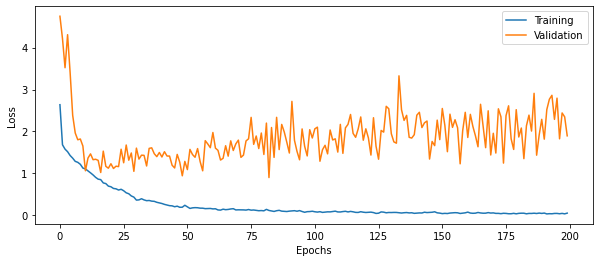

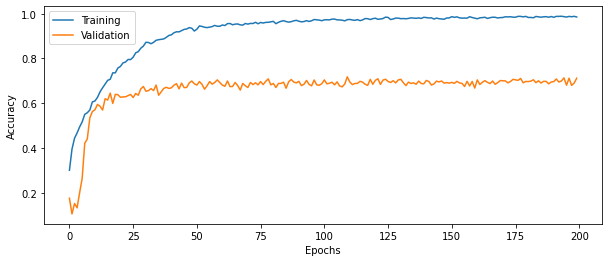

In [123]:
# Plot the history from the training run
plot_results(history6)

## Part 20: Plot misclassified images

Lets plot some images where the CNN performed badly

In [0]:
# Find misclassified images
y_pred = model6.predict_classes(Xtest)
y_correct = np.argmax(Ytest_categorical,axis=1)

miss = np.flatnonzero(y_correct != y_pred)

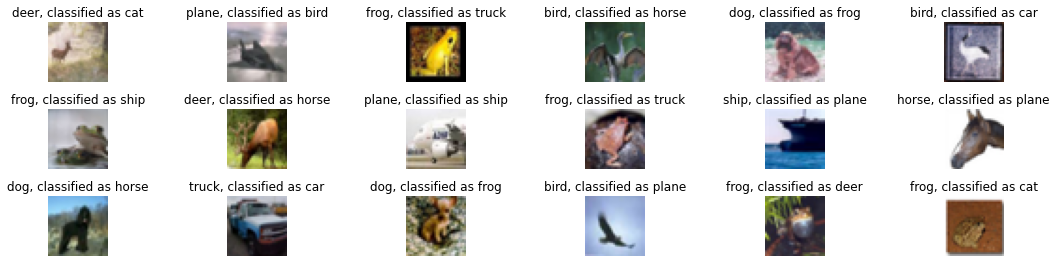

In [125]:
# Plot a few of them
plt.figure(figsize=(15,4))
perm = np.random.permutation(miss)
for i in range(18):
    im = (Xtest[perm[i]] + 1) * 127.5
    im = im.astype('int')
    label_correct = y_correct[perm[i]]
    label_pred = y_pred[perm[i]]
    
    plt.subplot(3,6,i+1)
    plt.tight_layout()
    plt.imshow(im)
    plt.axis('off')
    plt.title("{}, classified as {}".format(classes[label_correct], classes[label_pred]))
plt.show()

##  Part 21: Testing on another size

Question 27: This CNN has been trained on 32 x 32 images, can it be applied to images of another size? If not, why is this the case?

Answer 27: No, our CNN trained on 32 x 32 images cannot be applied to images of another size because it is not a fully convolutional network. We have intermediate dense layers. In case of a dense layer, its parameters are predefined. Hence the input dimensions which goes to the dense layer are fixed.

Question 28: Is it possible to design a CNN that can be trained on images of one size, and then applied to an image of any size? How?

Answer 28: Yes, a fully convolutional network can be trained on images of size A and then applied on images of size B. A fully convolutional network contains only convolutional layers and does not have any dense layers. Instead it has 1 x 1 convolutions that perform the task of fully connected layers. The input to the 1 x 1 convolution layer could be anything as long as the number of filters in 1 x 1 convolution layer (i.e. input to the final dense layer) is equal to the number of classes.

##  Part 22: Pre-trained 2D CNNs

There are many deep 2D CNNs that have been pre-trained using the large ImageNet database. Import a pre-trained ResNet50 network from Keras applications. Show the network using `model.summary()`

Question 29: How many convolutional layers does ResNet50 have? 

Answer 20: it is 18 convolutional layers.

Question 30: How many trainable parameters does the ResNet50 network have? 

Answer 30: Total params: 25,636,712
Trainable params: 25,583,592
Non-trainable params: 53,120

Question 31: What is the size of the images that ResNet50 expects as input?

Answer 31: The Input size is 224X224 is expected as input.

Question 32: Using the answer to question 30, explain why the second derivative is seldom used when training deep networks.

Answer 32: The number of trainable parameters in CNN is very high hence it is computationally taxing to optimize the second derivative.

Apply the pre-trained CNN to 5 random color images that you download and copy to the cloud machine. Are the predictions correct? How certain is the network of each image class?

These pre-trained networks can be fine tuned to your specific data, and normally only the last layers need to be re-trained, but it will still be too time consuming to do in this laboration.

See https://keras.io/applications/#resnet

Useful functions

`image.load_img` in keras.preprocessing

`image.img_to_array` in keras.preprocessing

`ResNet50` in keras.applications.resnet50

`preprocess_input` in keras.applications.resnet50

`decode_predictions` in keras.applications.resnet50

`expand_dims` in numpy


In [126]:
# Your code for using pre-trained ResNet 50 on 5 color images of your choice
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

model = ResNet50(weights='imagenet')
model.summary()


Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [127]:
img_path = '/content/drive/My Drive/Colab Notebooks/CIFAR/elephant.jpg'
img1 = image.load_img(img_path, target_size=(224, 224))

img_path='/content/drive/My Drive/Colab Notebooks/CIFAR/bird.jpg'
img2=image.load_img(img_path,target_size=(224, 224))

img_path='/content/drive/My Drive/Colab Notebooks/CIFAR/cat.jpg'
img3=image.load_img(img_path,target_size=(224, 224))

img_path='/content/drive/My Drive/Colab Notebooks/CIFAR/dog.jpg'
img4=image.load_img(img_path,target_size=(224, 224))

img_path='/content/drive/My Drive/Colab Notebooks/CIFAR/plane.jpg'
img5=image.load_img(img_path,target_size=(224, 224))

x1 = image.img_to_array(img1)
x1 = np.expand_dims(x1, axis=0)
x1 = preprocess_input(x1)

preds1 = model.predict(x1)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
print('Predicted:', decode_predictions(preds1, top=3)[0])

x2 = image.img_to_array(img2)
x2 = np.expand_dims(x2, axis=0)
x2 = preprocess_input(x2)

preds2 = model.predict(x2)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
print('Predicted:', decode_predictions(preds2, top=3)[0])

x3 = image.img_to_array(img3)
x3 = np.expand_dims(x3, axis=0)
x3 = preprocess_input(x3)

preds3 = model.predict(x3)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
print('Predicted:', decode_predictions(preds3, top=3)[0])

x4 = image.img_to_array(img4)
x4 = np.expand_dims(x4, axis=0)
x4 = preprocess_input(x4)

preds4 = model.predict(x4)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
print('Predicted:', decode_predictions(preds4, top=3)[0])

x5 = image.img_to_array(img5)
x5 = np.expand_dims(x5, axis=0)
x5 = preprocess_input(x5)

preds5 = model.predict(x5)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
print('Predicted:', decode_predictions(preds5, top=3)[0])



Predicted: [('n01871265', 'tusker', 0.5083545), ('n02504458', 'African_elephant', 0.43108356), ('n02504013', 'Indian_elephant', 0.060561955)]
Predicted: [('n01843065', 'jacamar', 0.2546135), ('n01828970', 'bee_eater', 0.21095861), ('n01833805', 'hummingbird', 0.0714088)]
Predicted: [('n02328150', 'Angora', 0.2735013), ('n02123394', 'Persian_cat', 0.04534975), ('n02112018', 'Pomeranian', 0.044995956)]
Predicted: [('n02094433', 'Yorkshire_terrier', 0.8416743), ('n02097658', 'silky_terrier', 0.11025298), ('n02096294', 'Australian_terrier', 0.046831023)]
Predicted: [('n02690373', 'airliner', 0.56933206), ('n04592741', 'wing', 0.1674229), ('n04552348', 'warplane', 0.13123202)]
